<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/GoingDeeper/GoingDeeper_NLP10_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
# ! pip install sentencepiece=='0.1.96'

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [ ]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from konlpy.tag import Mecab

import time
import re
import os
import io
import random

## 1. 데이터 전처리

In [ ]:
data_dir = '/content/drive/MyDrive/Colab/Datasets/kor_eng_park'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    raw = zip(kor, eng)
    cleaned_corpus = set(raw)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
len(cleaned_corpus)

78968

In [ ]:
corpus_kor, corpus_eng = zip(*cleaned_corpus)

In [ ]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [ ]:
enc_corpus = []
dec_corpus = []

for kor, eng in zip(corpus_kor, corpus_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng)

    enc_corpus.append(temp_kor)
    dec_corpus.append(temp_eng)

In [ ]:
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500])

korean data size: 78968
english data size: 78968
Korean: 또한 부부간 대화에 문제가 있다면 부부가 빨리 결혼 상담을 받으라고 권했다 .
English: courtenay recommended that men with a history of depression see a mental health professional before the birth of a child to work through any issues that are causing stress and anxiety .


In [ ]:
import sentencepiece as spm

kor_temp_path = 'korean-english-kor.temp.txt'
eng_temp_path = 'korean-english-eng.temp.txt'

with open(kor_temp_path, 'w') as f:
    for row in enc_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

with open(eng_temp_path, 'w') as f:
    for row in dec_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')


In [ ]:
def generate_tokenizer(vocab_size=20000,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    

    if lang=="ko":
        spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix=kor_spm --vocab_size={}'.format(kor_temp_path, vocab_size))

        tokenizer = spm.SentencePieceProcessor()
        tokenizer.load('kor_spm.model')

    elif lang=="en":
        spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix=eng_spm --vocab_size={}'.format(eng_temp_path, vocab_size))

        tokenizer = spm.SentencePieceProcessor()
        tokenizer.load('eng_spm.model')

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [ ]:
from tqdm.notebook import tqdm 
tqdm(range(len(enc_corpus)))

  0%|          | 0/78968 [00:00<?, ?it/s]

In [ ]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(enc_corpus) == len(dec_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(enc_corpus))):
    kor_tokenized = ko_tokenizer.encode_as_ids(enc_corpus[idx])
    eng_tokenized = en_tokenizer.encode_as_ids(dec_corpus[idx])
    if(len(kor_tokenized) <= 50):
        src_corpus.append(kor_tokenized)
        tgt_corpus.append(eng_tokenized)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [ ]:
print(len(enc_train))
print(len(dec_train))

77334
77334


## 2. 트랜스포머 모델 설계

Postional Encoding

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

Multi-Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        #Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        #1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)

        #2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        # Step 1.
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        # Step 2.
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        # Step 3.
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        # Step 4.
        out = self.combine_heads(out)

        # Step 5.
        out = self.linear(out)

        return out, attention_weights

Position-Wise FFN

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

Decoder Layer

In [ ]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

Transformer 클래스

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """

        # 1.
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        # 2.
        self.pos_encoding = positional_encoding(pos_len, d_model)        

        # 6.
        self.dropout = tf.keras.layers.Dropout(dropout)

        # 3.
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        # 4.
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        # 5.
        self.shared = shared

        if shared : self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """

        # 1. 
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        # 2.
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # 3.
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        # 4.
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


Masking 

In [ ]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

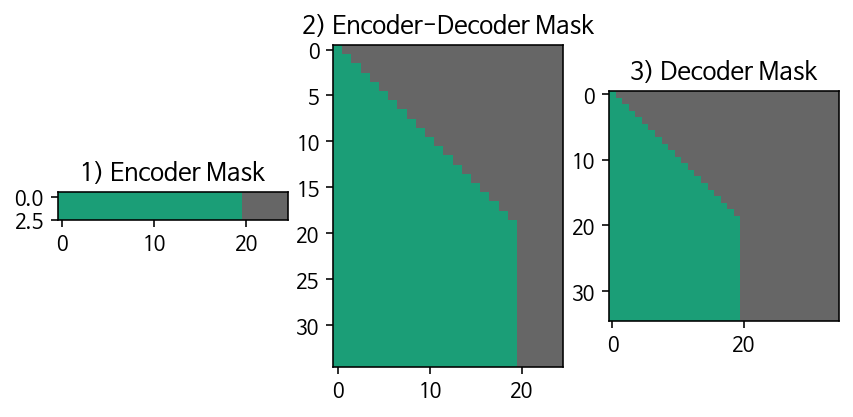

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

Learning Rate

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## 3. 훈련하기

In [ ]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=64,  
                          d_ff=2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=len(enc_train), 
                          shared=True)

논문과 동일한 optimizer 파라미터 설정 및 Learning Rate Scheduler 선언

In [ ]:
learning_rate = LearningRateScheduler(d_model=512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

Loss함수 정의

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
        gradients = tape.gradient(loss, model.trainable_variables)

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer, 
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama s obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city struck .
Input: 커피는 필요 없다.
Predicted translation: the first time the very good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the attack on sunday the attack killed the attack .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a major high .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were killed tuesday .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a strong presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban city s morning .
Input: 커피는 필요 없다.
Predicted translation: the coffee it s not just just just a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the total of people died sunday afternoon .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the very confident that obama s a .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the san s san s sanford .
Input: 커피는 필요 없다.
Predicted translation: the coffee retailer s home of the list of shoes .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the rural residents .
Input: 커피는 필요 없다.
Predicted translation: the coffee sales needed for the world .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll from the number of people s dead .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a win .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of albanian city .
Input: 커피는 필요 없다.
Predicted translation: the list is needed to open the world s top eligible payment of coffee table .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven other people struck the seventh personnelka sub toll from the seventh persons .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the illinois senator .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re a urban urbana .
Input: 커피는 필요 없다.
Predicted translation: the latest list needed needed needed needed to be needed places in need to be made coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven seven seventh of seven others were among seven deaths .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a little good .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city just a urban r seat .
Input: 커피는 필요 없다.
Predicted translation: the needed for needed . needed for needed a small needed needed needed needed to open and needed a list or needed needed needed needed needed needed needed needed needed needed needed needed needed needed needed needed needed for needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the illinois senator .
Input: 시민들은 도시 속에 산다.
Predicted translation: city the city .
Input: 커피는 필요 없다.
Predicted translation: it s needed to catch coffee table .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven with seven deaths . . . . . . . . . . . . . . . . kennedy sc . express sub headquarters .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city in the city .
Input: 커피는 필요 없다.
Predicted translation: it s not needed for needed to add necessary to bet than it is needed for sure .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven other seven deaths .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a win .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city .
Input: 커피는 필요 없다.
Predicted translation: the practice is needed for needed to open to place .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven in seven with seven without seventy seven with seven .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city in the city of fulfill light .
Input: 커피는 필요 없다.
Predicted translation: the list is needed for a fifth needed needed for the coffee and .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven in seven with seven deaths .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a little concert .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city .
Input: 커피는 필요 없다.
Predicted translation: the list needed for women needed a fifth meaning and coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a fourth person is on the fatalities of seven with seven aboard five of seven with seven astronauts .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s the illinois senator .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city their city .
Input: 커피는 필요 없다.
Predicted translation: the list needed needed ahead .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven in seven seven seven seven hundreds of seven seven now seven now seven people .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city their power .
Input: 커피는 필요 없다.
Predicted translation: the coffee is needed needed ahead coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a four person death wednesday .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is just a member .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city .
Input: 커피는 필요 없다.
Predicted translation: the list it s at least that s victims .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seventeen seven people were on tuesday .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people struck there tuesday .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a member .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city they power in small towns .
Input: 커피는 필요 없다.
Predicted translation: there s no need for anyone need for it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people on thursday .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city their lights in urban rural towns .
Input: 커피는 필요 없다.
Predicted translation: the only way to needed for its flight to need to be add .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are still dead .


  0%|          | 0/1209 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the illinois ambassador .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city their christmas taxes .
Input: 커피는 필요 없다.
Predicted translation: the coffee he needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven other people reese .


시각화 결과

Input: 오바마는 대통령이다.
Predicted translation: obama is the illinois ambassador .
Encoder Layer 1


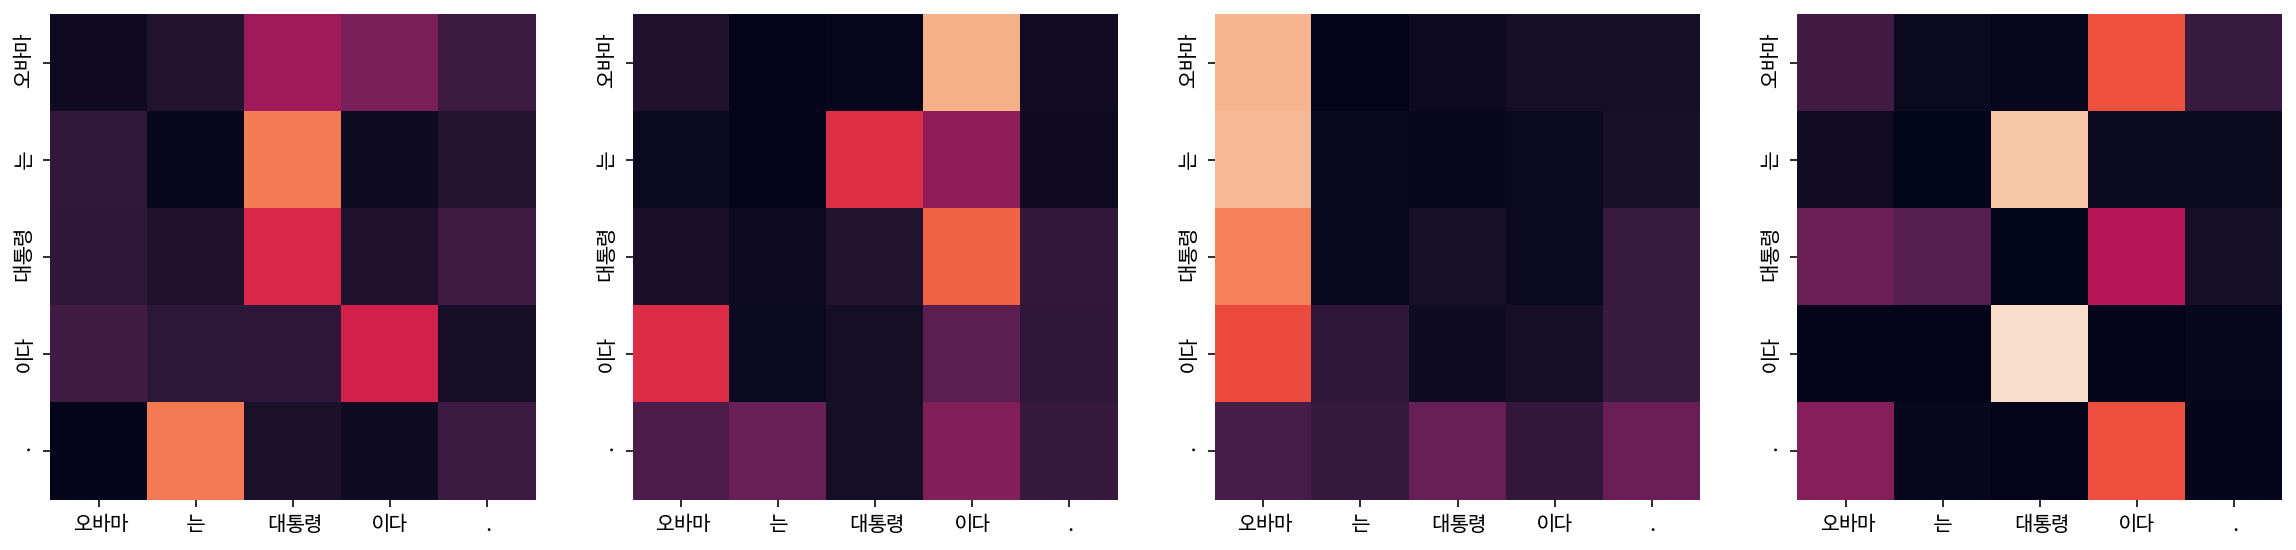

Encoder Layer 2


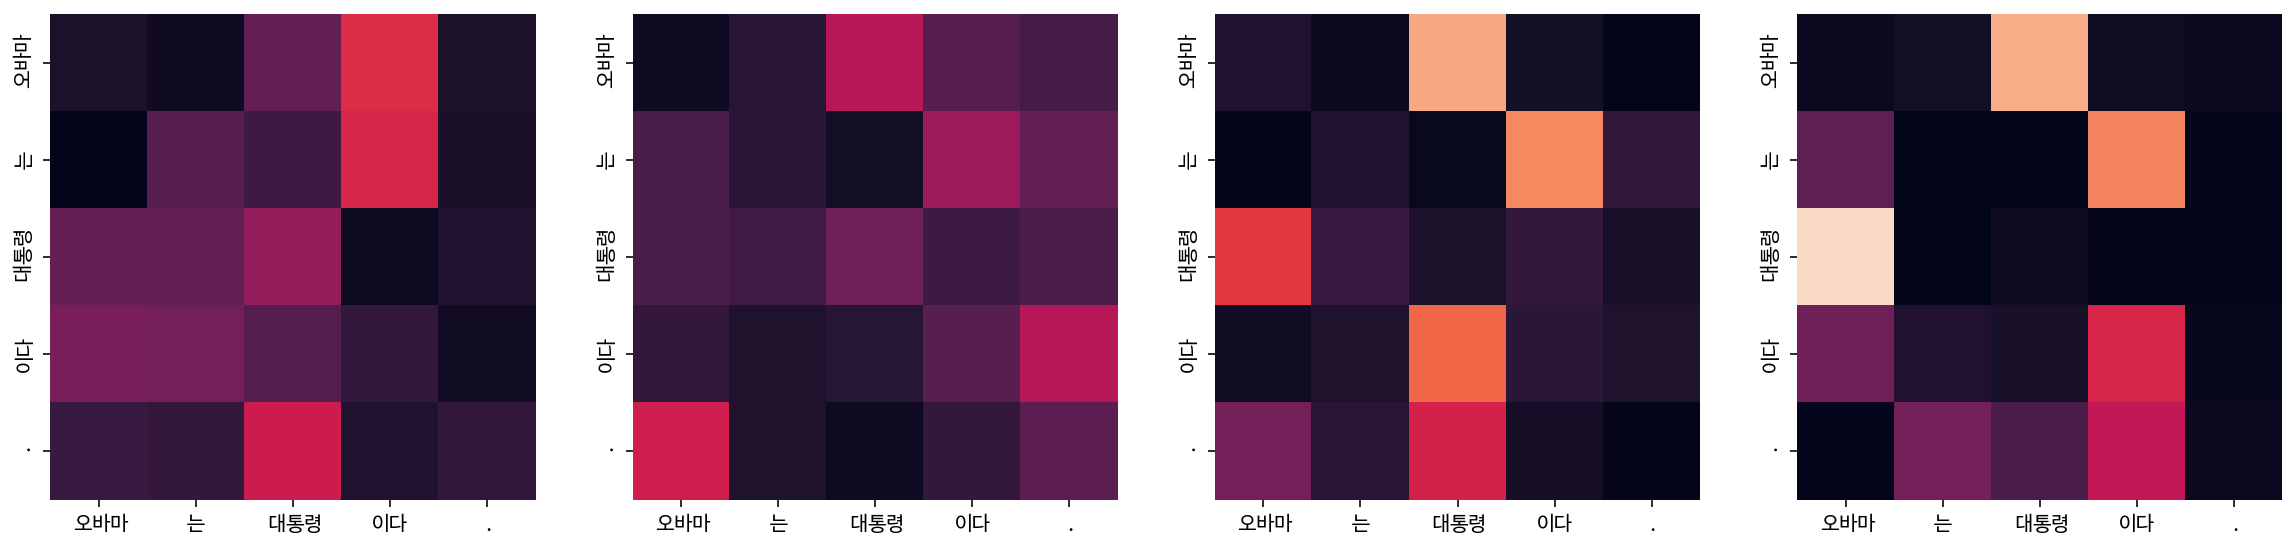

Decoder Self Layer 1


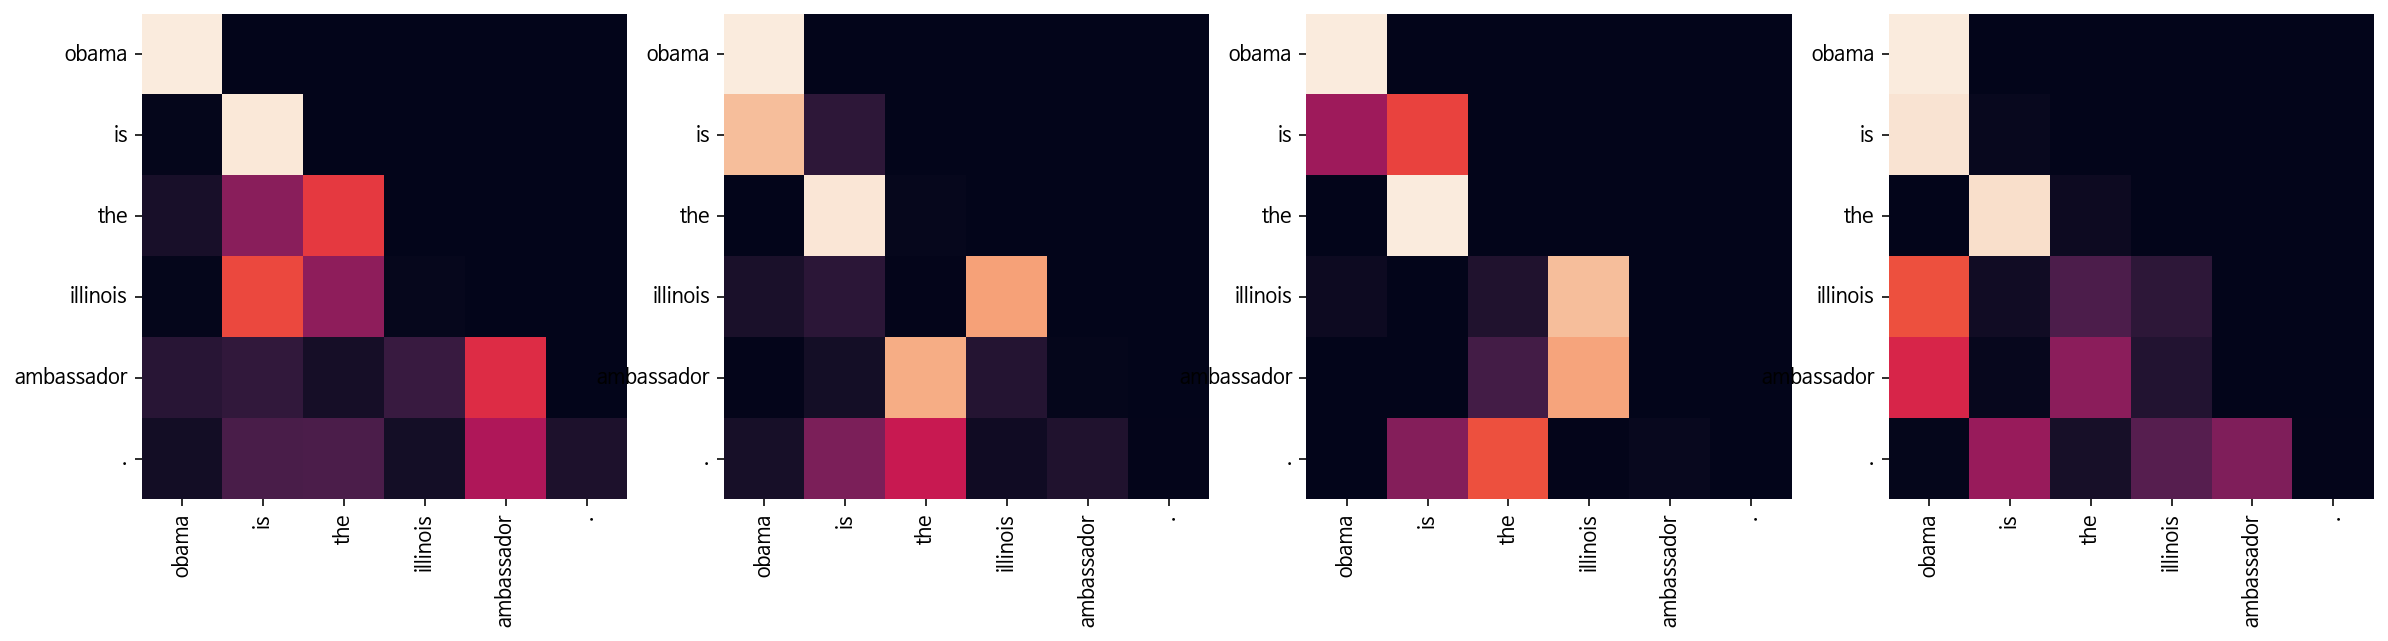

Decoder Src Layer 1


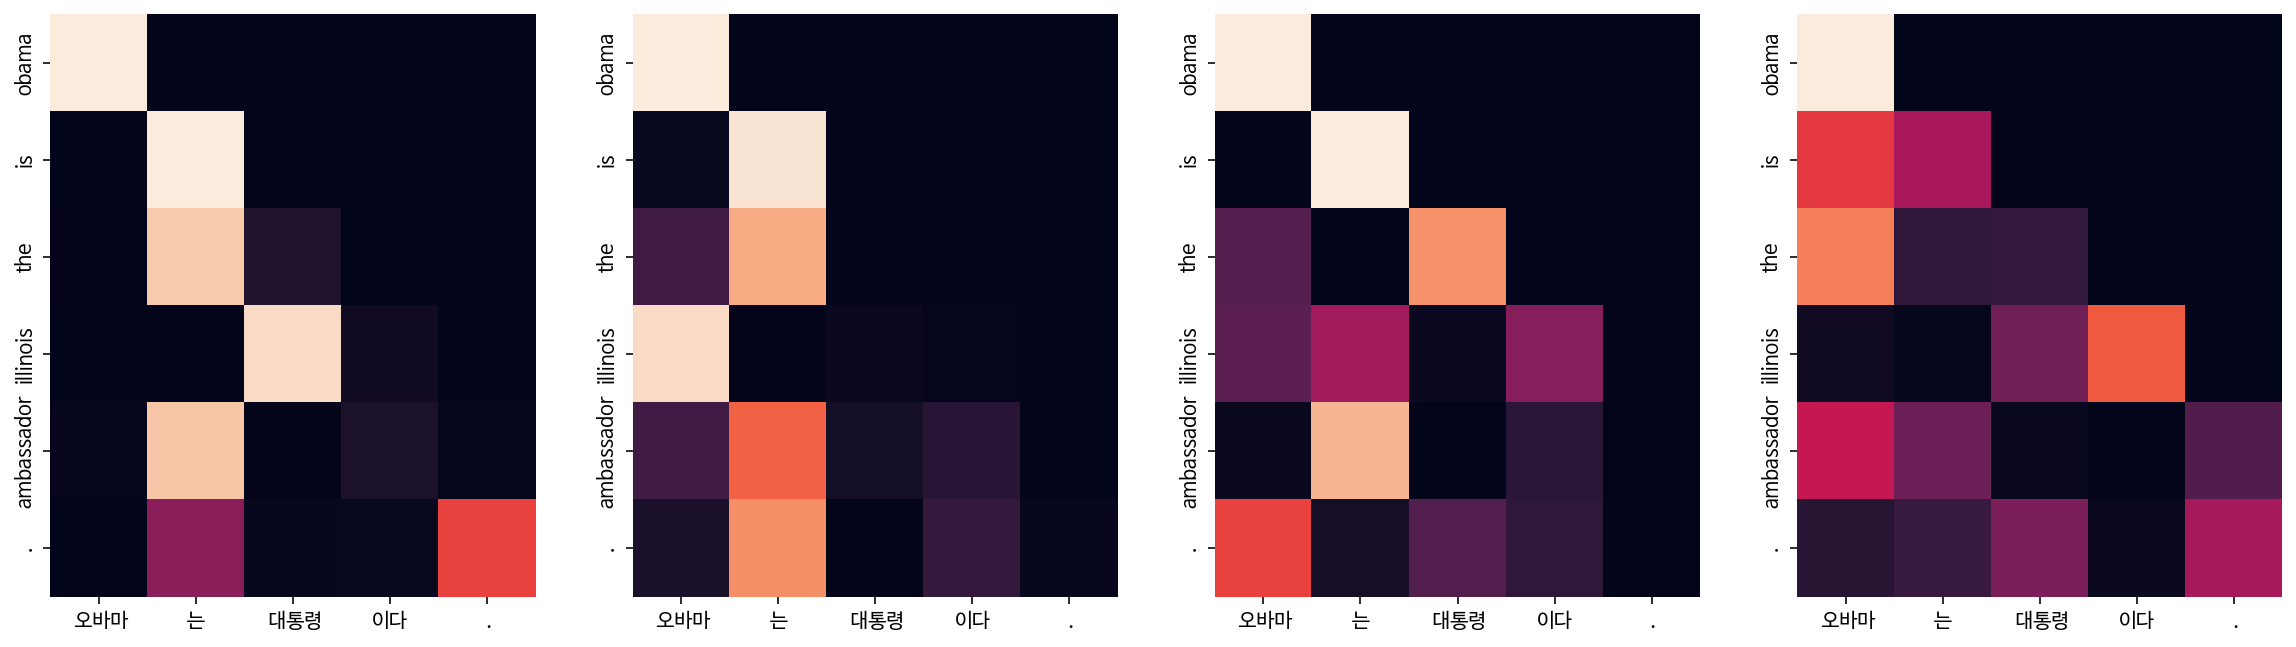

Decoder Self Layer 2


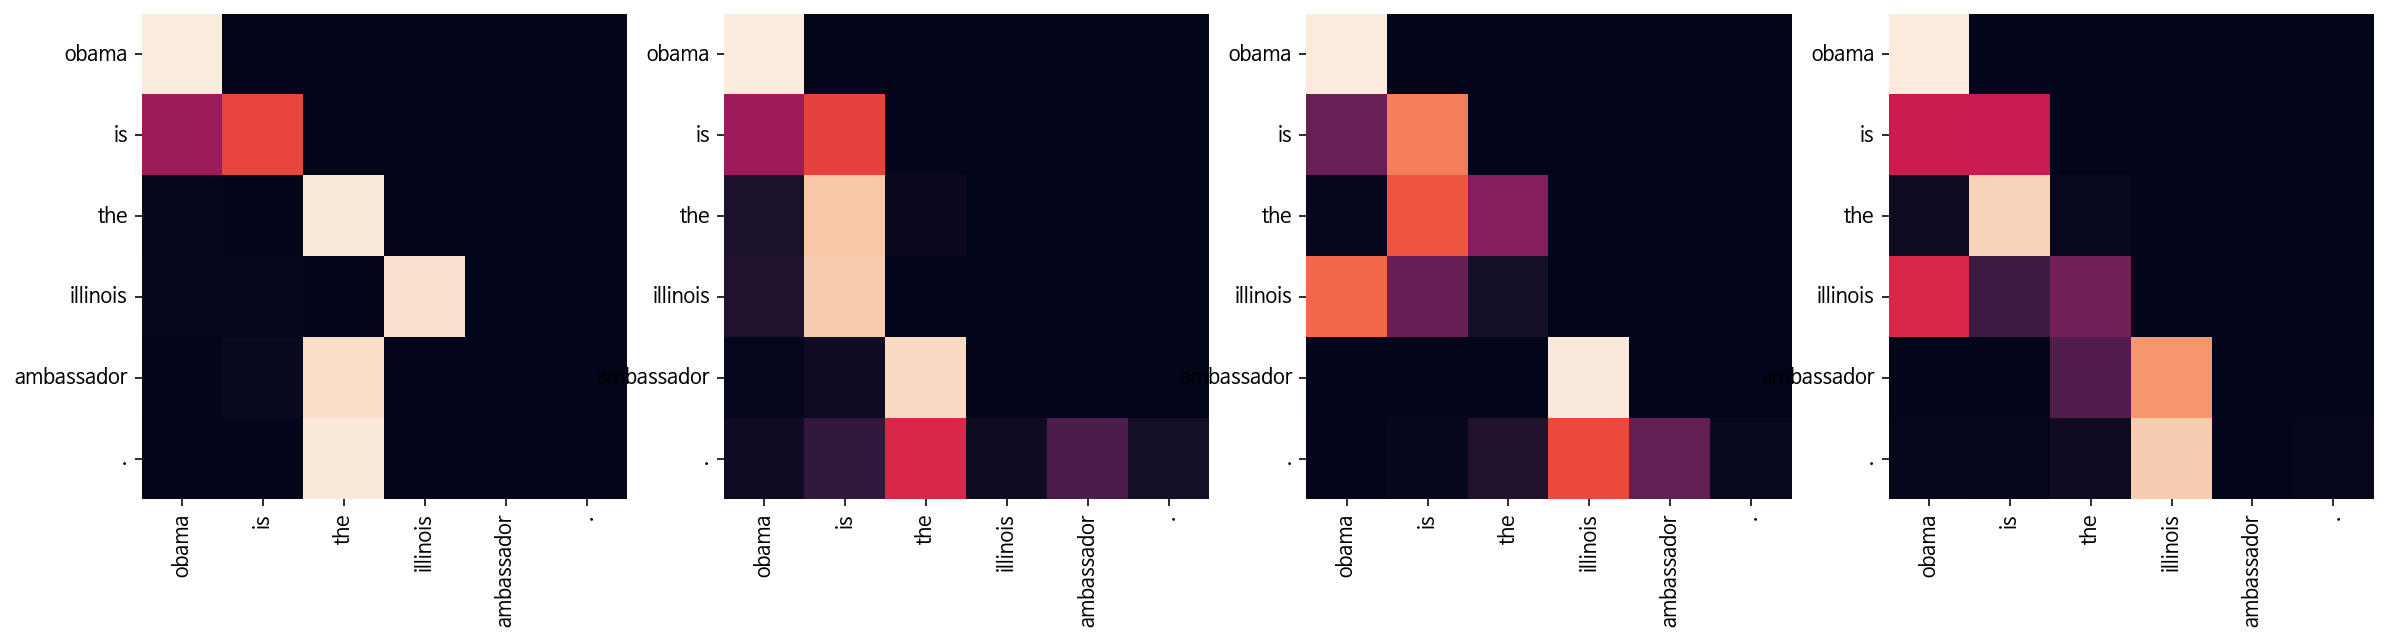

Decoder Src Layer 2


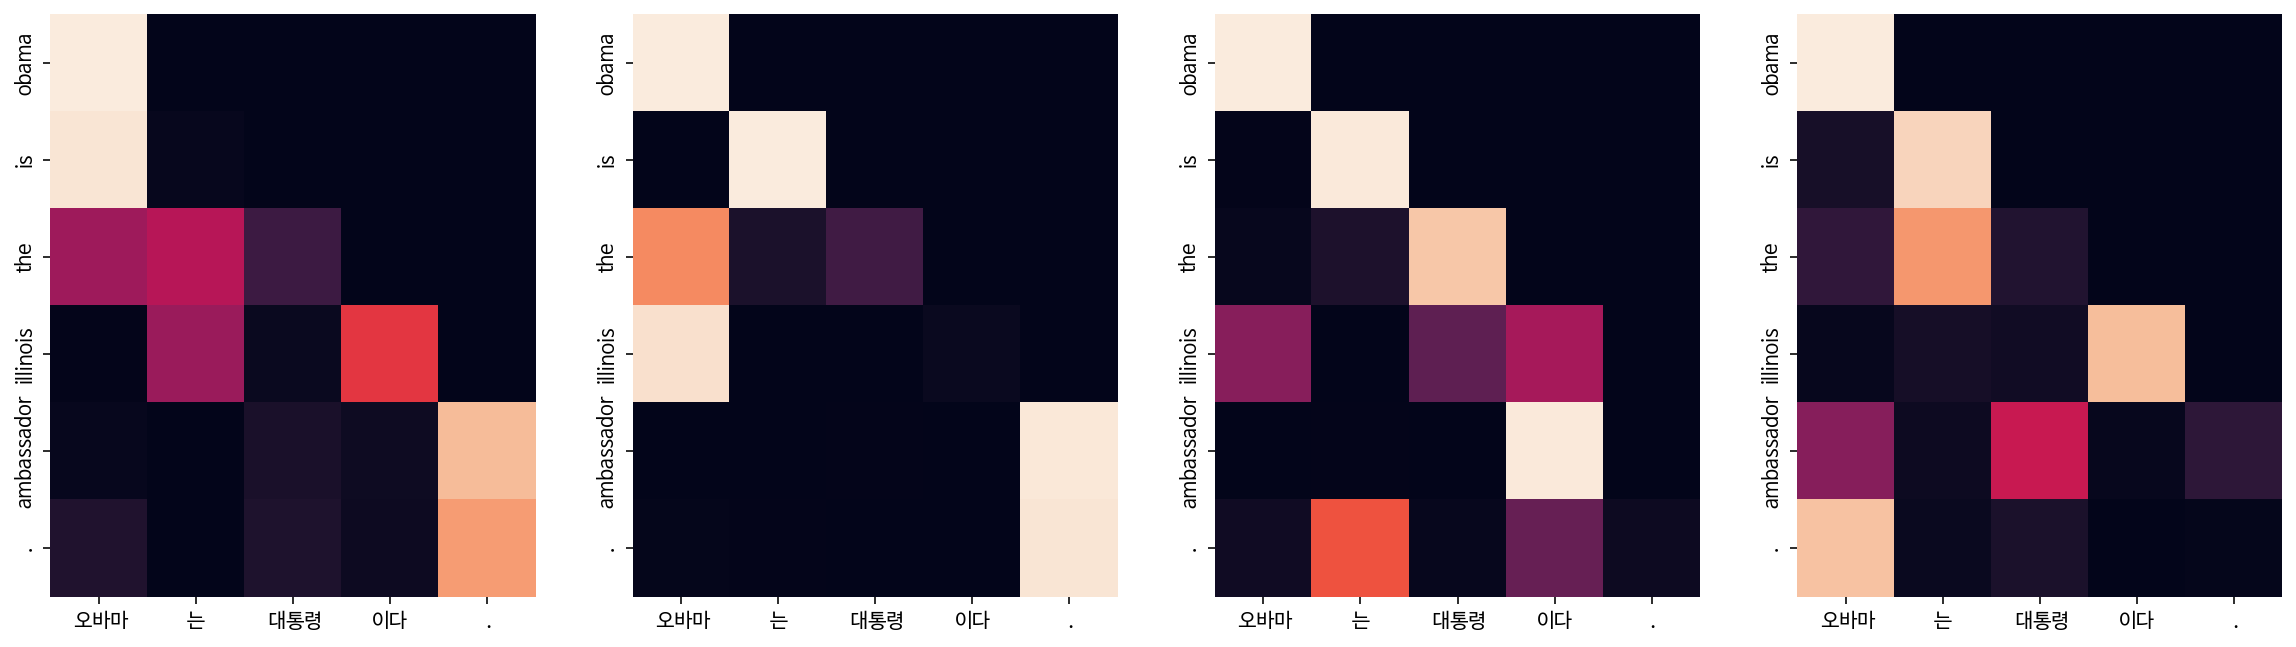

In [ ]:
translate("오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)


## 회고  
1. 진짜 어려웠던 만큼 seq2seq 에 비해 조금더 성능이 나아지는 것을 볼 수 있었다. 학습과정 중간중간을 보면 정말 완벽하게 번역을 해주는 부분도 있었다.  
2. 내가 코로나를 걸릴 생각은 못했는데 아픈 와중에 급하게 하려다보니 너무 정신이 없었다. 건강을 잘챙기자.